In [1]:
!pip install sklearn matplotlib shap seaborn 

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [15 lines of output]
  The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
  rather than 'sklearn' for pip commands.
  
  Here is how to fix this error in the main use cases:
  - use 'pip install scikit-learn' rather than 'pip install sklearn'
  - replace 'sklearn' by 'scikit-learn' in your pip requirements files
    (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
  - if the 'sklearn' package is used by one of your dependencies,
    it would be great if you take some time to track which package uses
    'sklearn' instead of 'scikit-learn' and report it to their issue tracker
  - as a last resort, set the environment variable
    SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
  
  More information is available at
  https://github.com/scikit-learn/sklearn-pypi-package
  [end of output]
  
  note: This error originates from a subpr

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import shap
warnings.filterwarnings('ignore')


In [3]:
# Load datasets
fifa_df = pd.read_csv('C:/Users/Pimri/Downloads/archive (5)/Fifa 23 Players Data.csv')
football_df = pd.read_csv('C:/Users/Pimri/OneDrive/Documenten/Football stats dataset.csv')


In [4]:
fifa_df.head()

,Known As,Full Name,Overall,Potential,Value(in Euro),Positions Played,Best Position,Nationality,Image Link,Age,...,LM Rating,CM Rating,RM Rating,LWB Rating,CDM Rating,RWB Rating,LB Rating,CB Rating,RB Rating,GK Rating
0,L. Messi,Lionel Messi,91,91,54000000,RW,CAM,Argentina,https://cdn.sofifa.net/players/158/023/23_60.png,35,...,91,88,91,67,66,67,62,53,62,22
1,K. Benzema,Karim Benzema,91,91,64000000,"CF,ST",CF,France,https://cdn.sofifa.net/players/165/153/23_60.png,34,...,89,84,89,67,67,67,63,58,63,21
2,R. Lewandowski,Robert Lewandowski,91,91,84000000,ST,ST,Poland,https://cdn.sofifa.net/players/188/545/23_60.png,33,...,86,83,86,67,69,67,64,63,64,22
3,K. De Bruyne,Kevin De Bruyne,91,91,107500000,"CM,CAM",CM,Belgium,https://cdn.sofifa.net/players/192/985/23_60.png,31,...,91,91,91,82,82,82,78,72,78,24
4,K. Mbappé,Kylian Mbappé,91,95,190500000,"ST,LW",ST,France,https://cdn.sofifa.net/players/231/747/23_60.png,23,...,92,84,92,70,66,70,66,57,66,21


In [5]:
football_df.head()

,player,team,name,position,height,age,appearance,goals,assists,yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger;
0,/david-de-gea/profil/spieler/59377,Manchester United,David de Gea,Goalkeeper,189.0,32.0,104,0.000000,0.000000,0.009585,...,1.217252,0.335463,9390,42,5,13,15000000,70000000,1,0;
1,/jack-butland/profil/spieler/128899,Manchester United,Jack Butland,Goalkeeper,196.0,30.0,15,0.000000,0.000000,0.069018,...,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,0;
2,/tom-heaton/profil/spieler/34130,Manchester United,Tom Heaton,Goalkeeper,188.0,37.0,4,0.000000,0.000000,0.000000,...,0.616438,0.924658,292,697,84,4,600000,6000000,1,0;
3,/lisandro-martinez/profil/spieler/480762,Manchester United,Lisandro Martínez,Defender Centre-Back,175.0,25.0,82,0.028090,0.056180,0.224719,...,0.000000,0.000000,6408,175,22,9,50000000,50000000,2,0;
4,/raphael-varane/profil/spieler/164770,Manchester United,Raphaël Varane,Defender Centre-Back,191.0,30.0,63,0.017889,0.017889,0.053667,...,0.000000,0.000000,5031,238,51,21,40000000,80000000,2,0;


In [6]:
# Preprocessing the FIFA dataset
# Assuming specific columns to drop - replace with actual columns if they are different
unnecessary_columns_fifa = ['Known As', 'Image Link']  # Update with actual column names
fifa_df.drop(columns=[col for col in unnecessary_columns_fifa if col in fifa_df.columns], errors='ignore', inplace=True)

# Preprocessing the Football Stats dataset
# Assuming 'player' is a duplicate column - update if the actual name is different
football_df.drop(columns=['player'], errors='ignore', inplace=True)

# Find common players in both datasets
common_players = fifa_df['Full Name'].isin(football_df['name'])
fifa_common_df = fifa_df[common_players]
football_common_df = football_df[football_df['name'].isin(fifa_df['Full Name'])]

# Merge datasets on common players
merged_df = pd.merge(fifa_common_df, football_common_df, left_on='Full Name', right_on='name')

# Handle missing values after merging
merged_df.fillna(merged_df.mean(numeric_only=True), inplace=True)
football_common_df.fillna(football_df.mean(numeric_only=True), inplace=True)

# Encoding categorical variables using one-hot encoding
merged_df = pd.get_dummies(merged_df, drop_first=True)
football_common_df = pd.get_dummies(football_common_df, drop_first=True)


In [7]:
fifa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18539 entries, 0 to 18538
Data columns (total 87 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Full Name                    18539 non-null  object
 1   Overall                      18539 non-null  int64 
 2   Potential                    18539 non-null  int64 
 3   Value(in Euro)               18539 non-null  int64 
 4   Positions Played             18539 non-null  object
 5   Best Position                18539 non-null  object
 6   Nationality                  18539 non-null  object
 7   Age                          18539 non-null  int64 
 8   Height(in cm)                18539 non-null  int64 
 9   Weight(in kg)                18539 non-null  int64 
 10  TotalStats                   18539 non-null  int64 
 11  BaseStats                    18539 non-null  int64 
 12  Club Name                    18539 non-null  object
 13  Wage(in Euro)                18

In [8]:
fifa_df.describe()

,Overall,Potential,Value(in Euro),Age,Height(in cm),Weight(in kg),TotalStats,BaseStats,Wage(in Euro),Release Clause,...,LM Rating,CM Rating,RM Rating,LWB Rating,CDM Rating,RWB Rating,LB Rating,CB Rating,RB Rating,GK Rating
count,18539.000000,18539.000000,1.853900e+04,18539.000000,18539.000000,18539.000000,18539.000000,18539.000000,18539.000000,1.853900e+04,...,18539.000000,18539.000000,18539.000000,18539.000000,18539.000000,18539.000000,18539.000000,18539.000000,18539.000000,18539.000000
mean,65.852042,71.016668,2.875461e+06,25.240412,181.550839,75.173904,1602.114569,357.946221,8824.537462,5.081688e+06,...,58.451319,57.374076,58.451319,56.281569,55.928583,56.281569,55.650251,54.528184,55.650251,23.257134
std,6.788353,6.192866,7.635129e+06,4.718163,6.858097,7.013593,273.160237,39.628259,19460.531154,1.467203e+07,...,13.987122,13.171194,13.987122,13.903836,13.872190,13.903836,14.159466,14.743929,14.159466,15.108925
min,47.000000,48.000000,0.000000e+00,16.000000,155.000000,49.000000,759.000000,224.000000,0.000000,0.000000e+00,...,18.000000,18.000000,18.000000,17.000000,19.000000,17.000000,17.000000,18.000000,17.000000,10.000000
25%,62.000000,67.000000,4.750000e+05,21.000000,177.000000,70.000000,1470.000000,331.000000,1000.000000,6.650000e+05,...,54.000000,53.000000,54.000000,51.000000,48.000000,51.000000,49.000000,45.000000,49.000000,17.000000
50%,66.000000,71.000000,1.000000e+06,25.000000,182.000000,75.000000,1640.000000,358.000000,3000.000000,1.500000e+06,...,62.000000,60.000000,62.000000,59.000000,59.000000,59.000000,59.000000,58.000000,59.000000,18.000000
75%,70.000000,75.000000,2.000000e+06,29.000000,186.000000,80.000000,1786.000000,385.000000,8000.000000,3.400000e+06,...,67.000000,66.000000,67.000000,66.000000,66.000000,66.000000,65.000000,66.000000,65.000000,20.000000
max,91.000000,95.000000,1.905000e+08,44.000000,206.000000,105.000000,2312.000000,502.000000,450000.000000,3.667000e+08,...,92.000000,91.000000,92.000000,88.000000,89.000000,88.000000,87.000000,90.000000,87.000000,90.000000


In [9]:
football_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10754 entries, 0 to 10753
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   team                 10754 non-null  object 
 1   name                 10754 non-null  object 
 2   position             10754 non-null  object 
 3   height               10754 non-null  float64
 4   age                  10754 non-null  float64
 5   appearance           10754 non-null  int64  
 6   goals                10754 non-null  float64
 7   assists              10754 non-null  float64
 8   yellow cards         10754 non-null  float64
 9   second yellow cards  10754 non-null  float64
 10  red cards            10754 non-null  float64
 11  goals conceded       10754 non-null  float64
 12  clean sheets         10754 non-null  float64
 13  minutes played       10754 non-null  int64  
 14  days_injured         10754 non-null  int64  
 15  games_injured        10754 non-null 

In [10]:
football_df.describe()

,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded
count,10754.000000,10754.000000,10754.000000,10754.000000,10754.000000,10754.000000,10754.000000,10754.000000,10754.000000,10754.000000,10754.000000,10754.000000,10754.000000,10754.000000,1.075400e+04,1.075400e+04,10754.000000
mean,181.240353,26.041903,36.407011,0.125554,0.086978,0.189757,0.004666,0.006826,0.131655,0.044881,2470.789381,117.961689,15.826297,1.960759,3.622971e+06,6.152606e+06,2.713223
std,6.969818,4.777629,26.526541,0.235585,0.143351,0.432388,0.025232,0.081143,0.442335,0.924437,2021.703271,175.206827,23.383606,3.743936,9.095410e+06,1.338988e+07,0.986356
min,156.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,1.000000
25%,176.000000,22.000000,12.000000,0.000000,0.000000,0.053191,0.000000,0.000000,0.000000,0.000000,660.000000,0.000000,0.000000,0.000000,3.000000e+05,4.500000e+05,2.000000
50%,181.240353,26.000000,35.000000,0.045969,0.040773,0.150250,0.000000,0.000000,0.000000,0.000000,2101.500000,37.000000,5.000000,1.000000,8.000000e+05,1.500000e+06,3.000000
75%,186.000000,29.000000,59.000000,0.172263,0.133136,0.248276,0.000000,0.000000,0.000000,0.000000,3968.000000,181.000000,24.000000,2.000000,3.000000e+06,5.000000e+06,4.000000
max,206.000000,43.000000,107.000000,11.250000,4.000000,30.000000,1.000000,6.923077,9.000000,90.000000,9510.000000,2349.000000,339.000000,92.000000,1.800000e+08,2.000000e+08,4.000000


# # EDA for Fifa Dataset

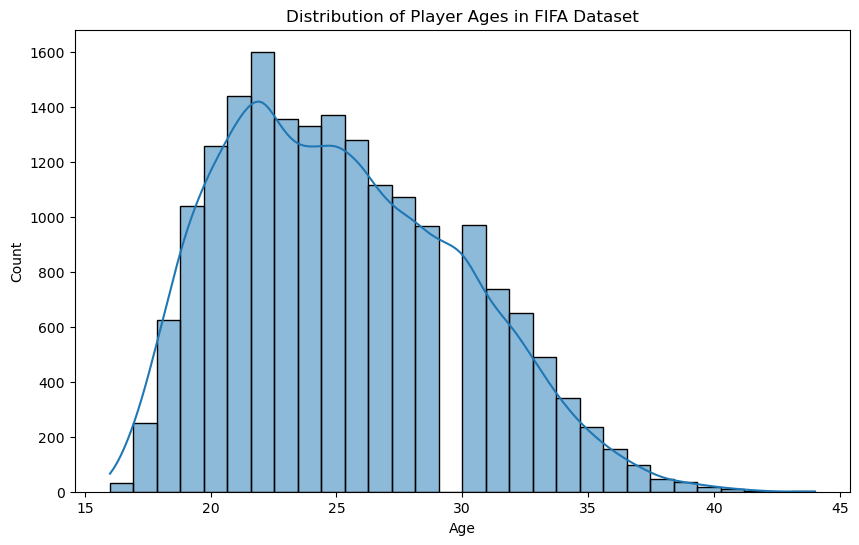

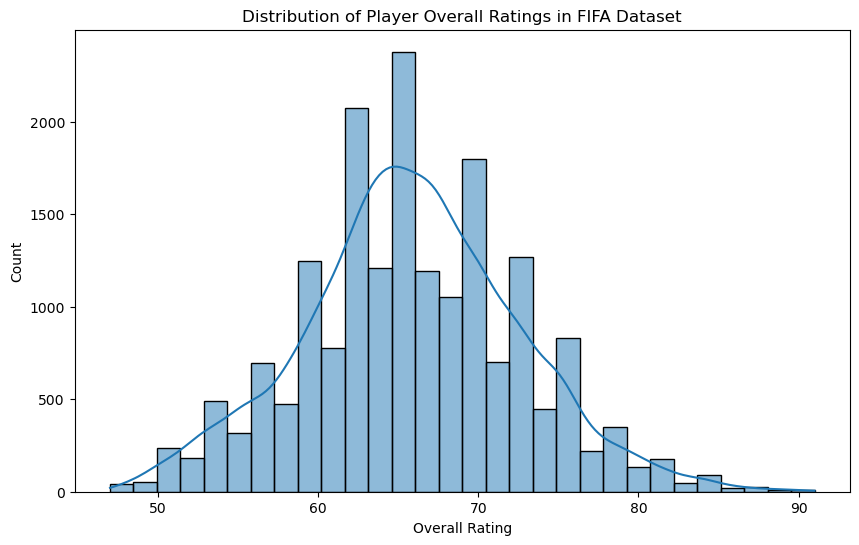

In [11]:
# Histogram of Player Ages
plt.figure(figsize=(10, 6))
sns.histplot(data=fifa_df, x='Age', bins=30, kde=True)
plt.title('Distribution of Player Ages in FIFA Dataset')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Histogram of Player Overall Ratings
plt.figure(figsize=(10, 6))
sns.histplot(data=fifa_df, x='Overall', bins=30, kde=True)
plt.title('Distribution of Player Overall Ratings in FIFA Dataset')
plt.xlabel('Overall Rating')
plt.ylabel('Count')
plt.show()

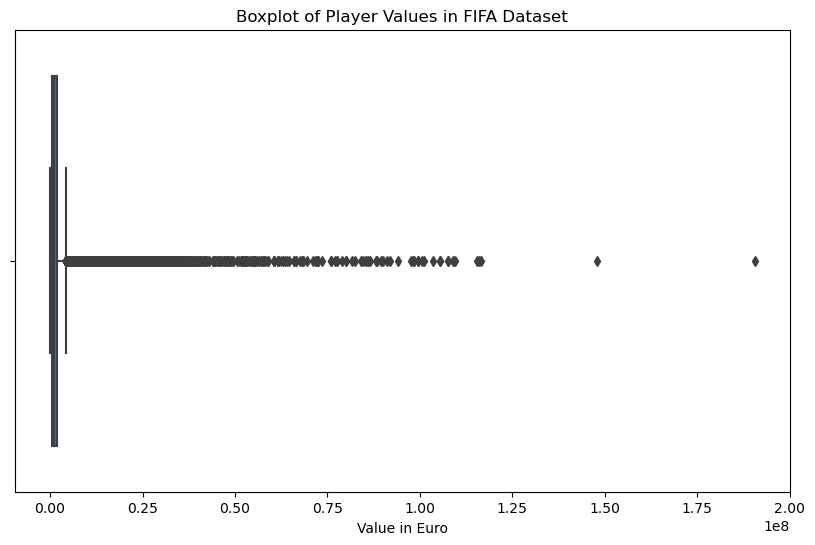

In [12]:
# Boxplot of Player Values
plt.figure(figsize=(10, 6))
sns.boxplot(data=fifa_df, x='Value(in Euro)')
plt.title('Boxplot of Player Values in FIFA Dataset')
plt.xlabel('Value in Euro')
plt.show()


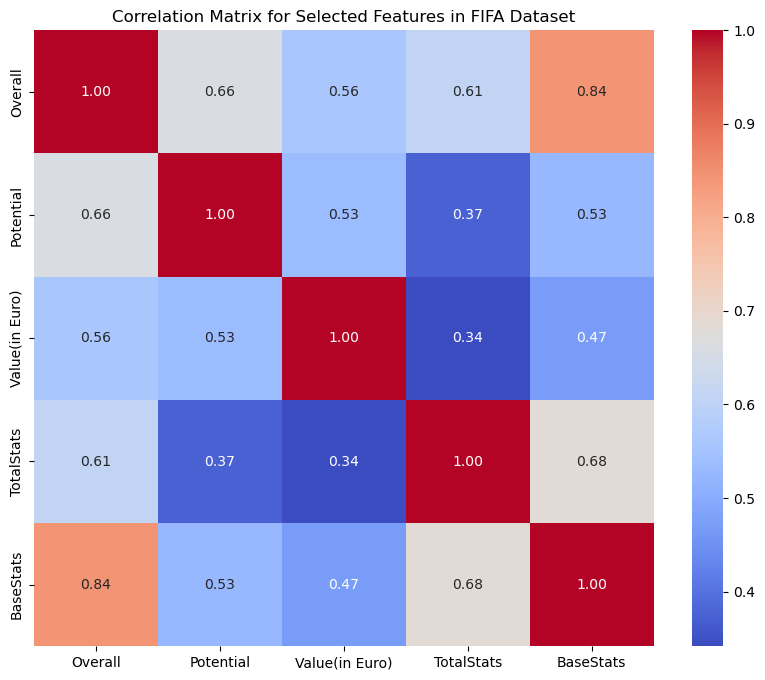

In [13]:
# Correlation heatmap for selected features
features = ['Overall', 'Potential', 'Value(in Euro)', 'TotalStats', 'BaseStats']
corr = fifa_df[features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for Selected Features in FIFA Dataset')
plt.show()


# EDA for Football Dataset

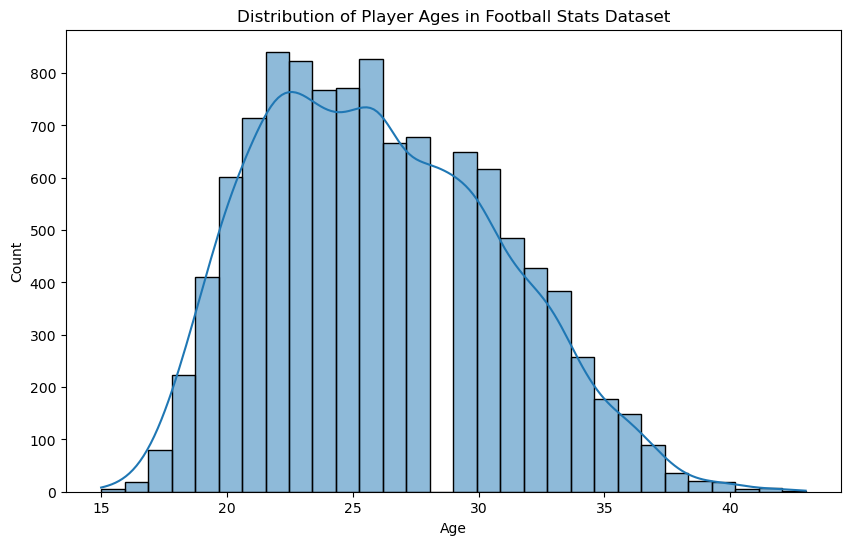

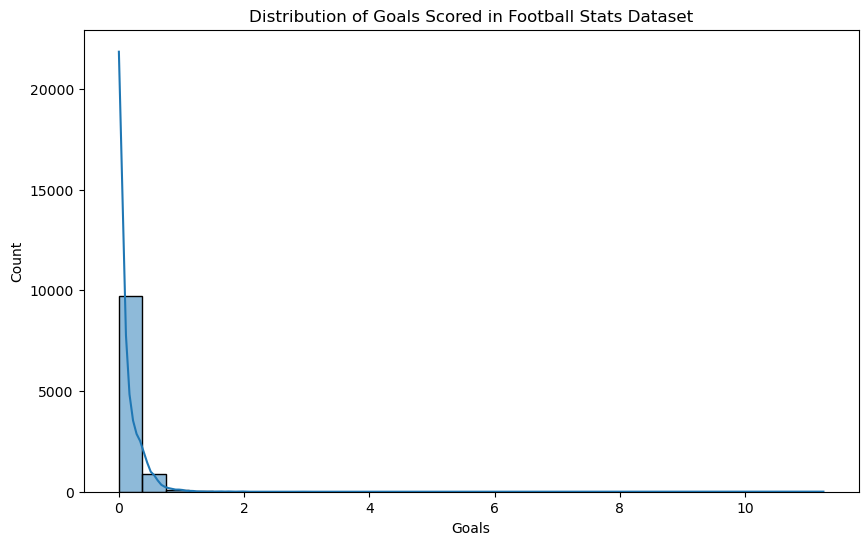

In [14]:
# Histogram of Player Ages
plt.figure(figsize=(10, 6))
sns.histplot(data=football_df, x='age', bins=30, kde=True)
plt.title('Distribution of Player Ages in Football Stats Dataset')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Histogram of Goals Scored
plt.figure(figsize=(10, 6))
sns.histplot(data=football_df, x='goals', bins=30, kde=True)
plt.title('Distribution of Goals Scored in Football Stats Dataset')
plt.xlabel('Goals')
plt.ylabel('Count')
plt.show()


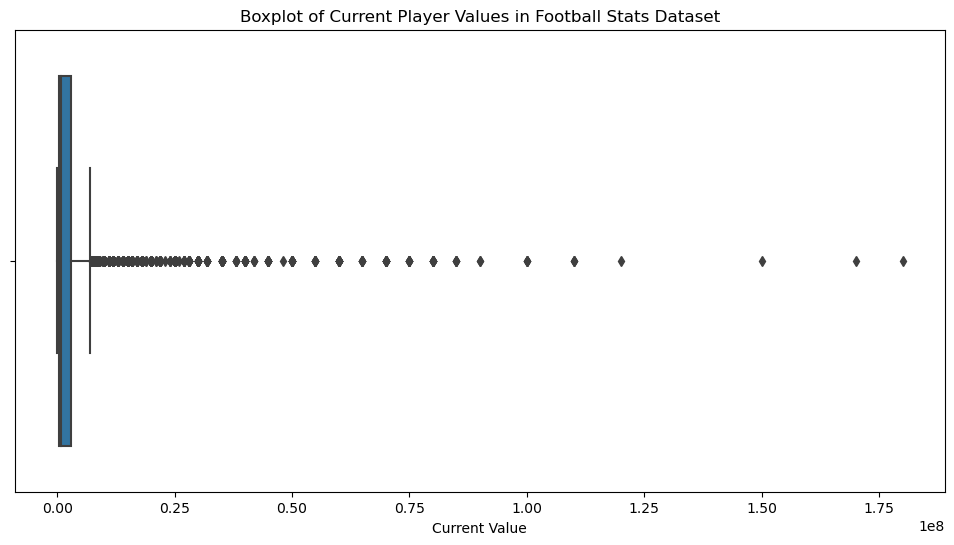

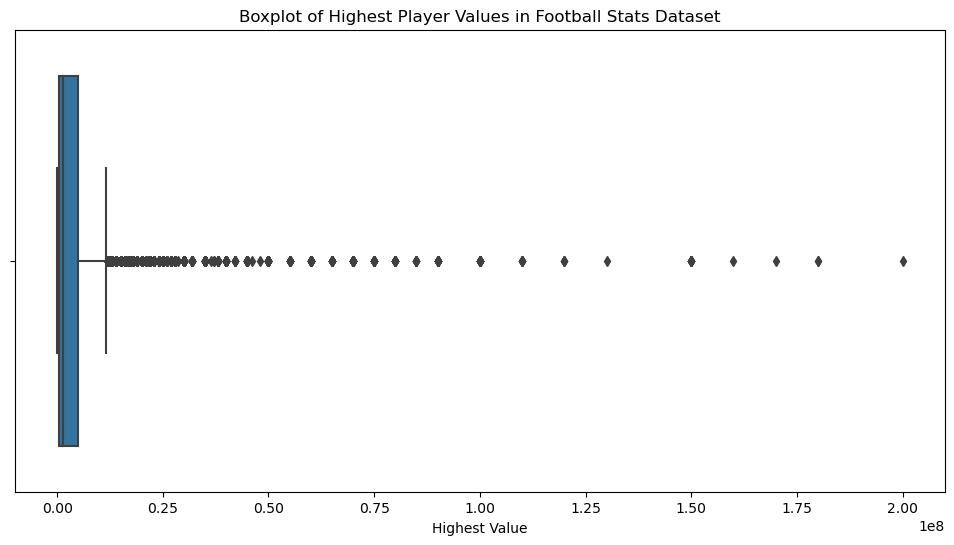

In [15]:
# Boxplot of Current and Highest Player Values
plt.figure(figsize=(12, 6))
sns.boxplot(data=football_df, x='current_value')
plt.title('Boxplot of Current Player Values in Football Stats Dataset')
plt.xlabel('Current Value')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=football_df, x='highest_value')
plt.title('Boxplot of Highest Player Values in Football Stats Dataset')
plt.xlabel('Highest Value')
plt.show()


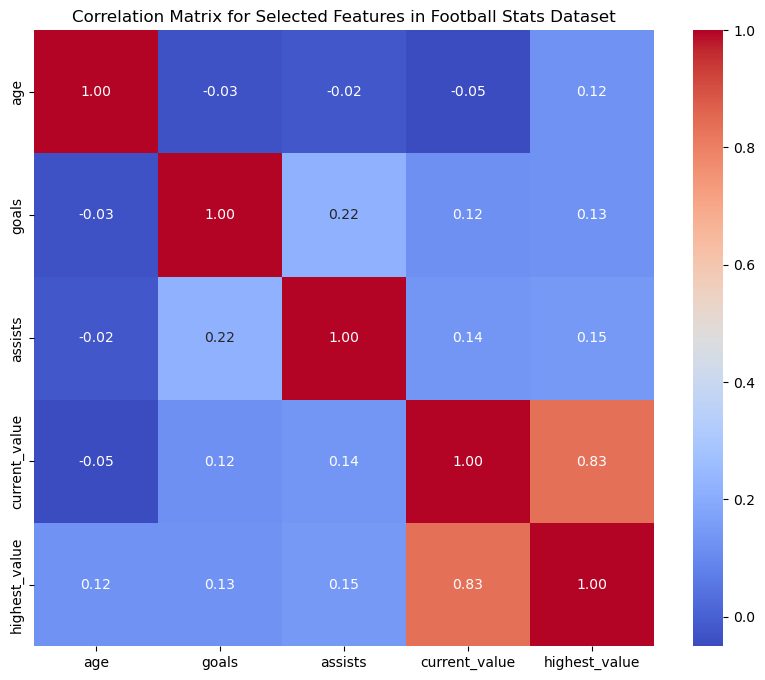

In [16]:
# Correlation heatmap for selected features
features_football = ['age', 'goals', 'assists', 'current_value', 'highest_value']
corr_football = football_df[features_football].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_football, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for Selected Features in Football Stats Dataset')
plt.show()


# EDA for Merged Dataset

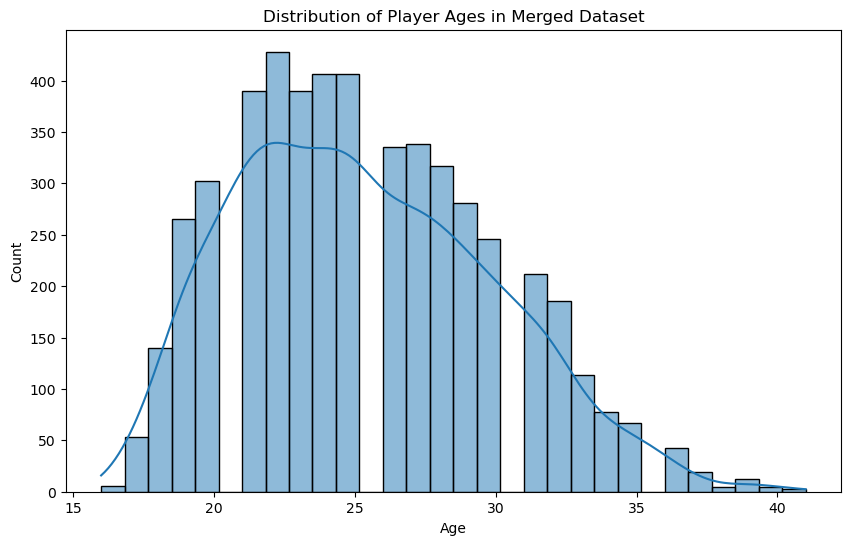

In [17]:
# Histogram of Player Ages
plt.figure(figsize=(10, 6))
sns.histplot(data=merged_df, x='Age', bins=30, kde=True)
plt.title('Distribution of Player Ages in Merged Dataset')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

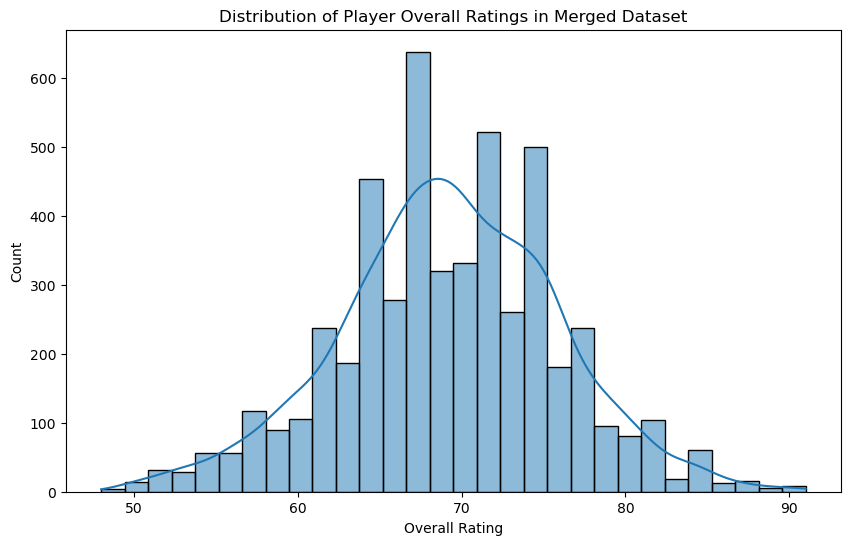

In [18]:

# Histogram of Player Overall Ratings
plt.figure(figsize=(10, 6))
sns.histplot(data=merged_df, x='Overall', bins=30, kde=True)
plt.title('Distribution of Player Overall Ratings in Merged Dataset')
plt.xlabel('Overall Rating')
plt.ylabel('Count')
plt.show()

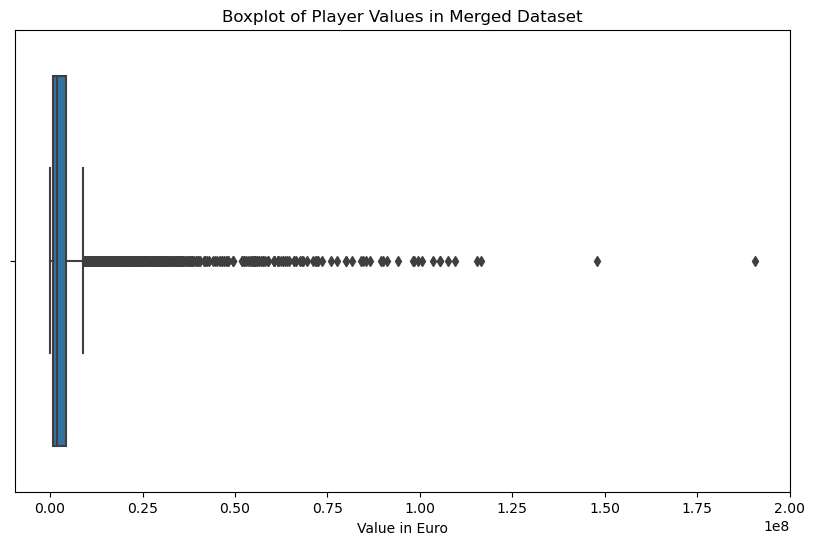

In [19]:
# Boxplot of Player Values
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_df, x='Value(in Euro)')
plt.title('Boxplot of Player Values in Merged Dataset')
plt.xlabel('Value in Euro')
plt.show()

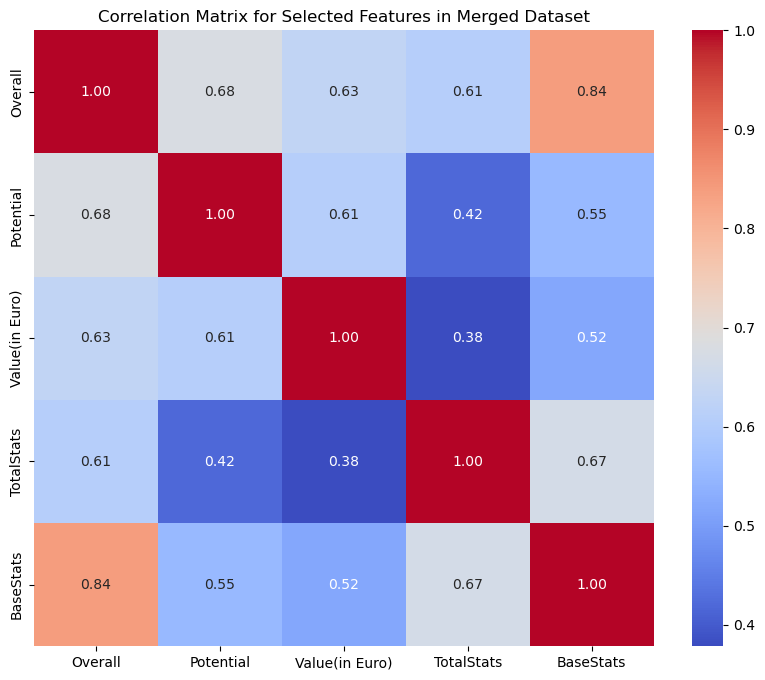

In [20]:
# Correlation heatmap for selected features
features = ['Overall', 'Potential', 'Value(in Euro)', 'TotalStats', 'BaseStats']
corr = merged_df[features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for Selected Features in Merged Dataset')
plt.show()


# Feature Engineering

In [21]:
# Feature Engineering
merged_df['Performance_Score'] = (
    merged_df['Pace Total'] + merged_df['Shooting Total'] + 
    merged_df['Passing Total'] + merged_df['Dribbling Total'] + 
    merged_df['Defending Total'] + merged_df['Physicality Total'] + 
    merged_df['goals'] * 0.4 + merged_df['assists'] * 0.3 + 
    merged_df['appearance'] * 0.3
)

# Feature Engineering for Football Stats Dataset
football_df['Performance_Score'] = football_df['goals'] * 0.4 + football_df['assists'] * 0.3 + football_df['appearance'] * 0.3


In [22]:
# Prepare the dataset
X = merged_df.drop(['Value(in Euro)', 'current_value', 'Known As', 'Image Link', 'Full Name', 'name'], axis=1, errors='ignore')
y = merged_df['Value(in Euro)']

# Ensure there is no issue with stratification by removing the stratify parameter
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [23]:
# Prepare FIFA Dataset

# Prepare Football Stats Dataset
X_football = football_common_df.drop(['current_value', 'player', 'team', 'name'], axis=1, errors='ignore')
y_football = football_common_df['current_value']
X_train_football, X_test_football, y_train_football, y_test_football = train_test_split(X_football, y_football, test_size=0.3, random_state=42)


# Training the Model

In [24]:
# Function to train and evaluate models directly returning the RMSE using the 'squared=False' parameter
def train_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)  # Directly calculate RMSE
    r2 = r2_score(y_test, y_pred)
    return rmse, r2

# Models
rf = RandomForestRegressor(n_estimators=100, random_state=42)
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Training and Evaluating on the merged dataset
rmse_rf, r2_rf = train_evaluate_model(rf, X_train, y_train, X_test, y_test)
rmse_gb, r2_gb = train_evaluate_model(gb, X_train, y_train, X_test, y_test)


# Training and Evaluating on Football Stats Dataset
rmse_rf_football, r2_rf_football = train_evaluate_model(rf, X_train_football, y_train_football, X_test_football, y_test_football)
rmse_gb_football, r2_gb_football = train_evaluate_model(gb, X_train_football, y_train_football, X_test_football, y_test_football)

# Print the results
print(f"Merged Dataset - Random Forest: RMSE = {rmse_rf}, R2 = {r2_rf}")
print(f"Merged Dataset - Gradient Boosting: RMSE = {rmse_gb}, R2 = {r2_gb}")
print(f"Football Stats Dataset - Random Forest: RMSE = {rmse_rf_football}, R2 = {r2_rf_football}")
print(f"Football Stats Dataset - Gradient Boosting: RMSE = {rmse_gb_football}, R2 = {r2_gb_football}")


Merged Dataset - Random Forest: RMSE = 1680392.1878242968, R2 = 0.9787745171950558
Merged Dataset - Gradient Boosting: RMSE = 1438069.4802871288, R2 = 0.9844548109142988
Football Stats Dataset - Random Forest: RMSE = 3975160.5052019884, R2 = 0.8978245993061106
Football Stats Dataset - Gradient Boosting: RMSE = 4008465.7268869886, R2 = 0.8961053077232851


# Hyper Parameter Tuning

In [25]:
# Hyperparameter Tuning for the merged dataset
param_grid = {
    'n_estimators': [10],
    'max_depth': [10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Create the Random Forest model
rf = RandomForestRegressor(random_state=42)

# Create the GridSearchCV model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best estimator
best_rf = grid_search.best_estimator_

# Evaluate the best model
y_pred = best_rf.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Best Parameters for Merged Dataset: {grid_search.best_params_}")
print(f"Best for Merged Dataset: RMSE = {rmse}, R2 = {r2}")


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters for Merged Dataset: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}
Best for Merged Dataset: RMSE = 1656772.7700300212, R2 = 0.9793670100711522


In [26]:
# Define the parameter grid for Gradient Boosting
param_grid_gb = {
    'n_estimators': [20],
    'max_depth': [10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# GridSearchCV for Gradient Boosting
grid_search_gb = GridSearchCV(estimator=GradientBoostingRegressor(random_state=42), 
                              param_grid=param_grid_gb, 
                              cv=5, 
                              scoring='neg_mean_squared_error', 
                              verbose=2, 
                              n_jobs=-1)
grid_search_gb.fit(X_train, y_train)
best_gb = grid_search_gb.best_estimator_

# Print the results
print(f"Merged Dataset - Best Gradient Boosting: RMSE = {rmse_gb}, R2 = {r2_gb}")

# Print the best hyperparameters
print(f"Best Parameters for Gradient Boosting: {grid_search_gb.best_params_}")


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Merged Dataset - Best Gradient Boosting: RMSE = 1438069.4802871288, R2 = 0.9844548109142988
Best Parameters for Gradient Boosting: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 20}


In [27]:
# Hyperparameter Tuning for Football Stats Dataset
# Setting up the parameter grid
param_grid_football = {
    'n_estimators': [10],
    'max_depth': [10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Create the Random Forest model
rf_football = RandomForestRegressor(random_state=42)

# Create the GridSearchCV model
grid_search_football = GridSearchCV(estimator=rf_football, param_grid=param_grid_football, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Fit GridSearchCV
grid_search_football.fit(X_train_football, y_train_football)

# Best estimator
best_rf_football = grid_search_football.best_estimator_

# Evaluate the best model
y_pred_football = best_rf_football.predict(X_test_football)
rmse_football = mean_squared_error(y_test_football, y_pred_football, squared=False)
r2_football = r2_score(y_test_football, y_pred_football)

print(f"Best Parameters for Football Stats Dataset: {grid_search_football.best_params_}")
print(f"Best RMSE for Football Stats Dataset: RMSE = {rmse_football}, R2 = {r2_football}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters for Football Stats Dataset: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 10}
Best RMSE for Football Stats Dataset: RMSE = 3863798.512145794, R2 = 0.9034691892883769


In [35]:
# Hyperparameter Tuning for Football Stats Dataset
# Setting up the parameter grid
param_grid_football_gb = {
    'n_estimators': [60],
    'max_depth': [10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
# Create the Gradient Boosting model
gb_football = GradientBoostingRegressor(random_state=42)

# Create the GridSearchCV model
grid_search_gb_football = GridSearchCV(estimator=gb_football, 
                                       param_grid=param_grid_football_gb, 
                                       cv=5, 
                                       scoring='neg_mean_squared_error', 
                                       verbose=2, 
                                       n_jobs=-1)

# Fit GridSearchCV
grid_search_gb_football.fit(X_train_football, y_train_football)

# Best estimator
best_gb_football = grid_search_gb_football.best_estimator_

# Evaluate the best model
y_pred_gb_football = best_gb_football.predict(X_test_football)
rmse_gb_football = mean_squared_error(y_test_football, y_pred_gb_football, squared=False)
r2_gb_football = r2_score(y_test_football, y_pred_gb_football)

# Print the results
print(f"Best Parameters for Football Stats Dataset (Gradient Boosting): {grid_search_gb_football.best_params_}")
print(f"Best RMSE for Football Stats Dataset (Gradient Boosting): RMSE = {rmse_gb_football}, R2 = {r2_gb_football}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters for Football Stats Dataset (Gradient Boosting): {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 60}
Best RMSE for Football Stats Dataset (Gradient Boosting): RMSE = 4027245.5609796043, R2 = 0.8951295250823851


# Model Evaluation

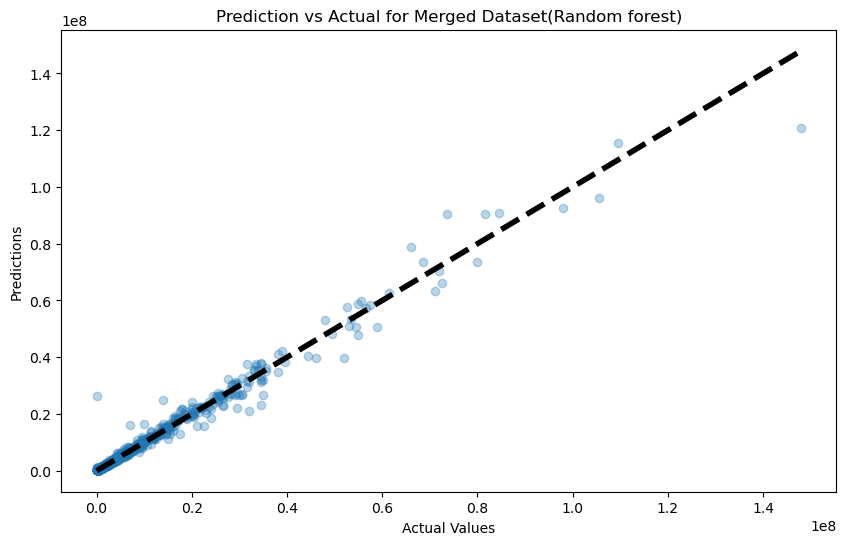

In [36]:
# Predictions
y_pred = best_rf.predict(X_test)

# Merged Dataset Prediction vs Actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title('Prediction vs Actual for Merged Dataset(Random forest)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.show()







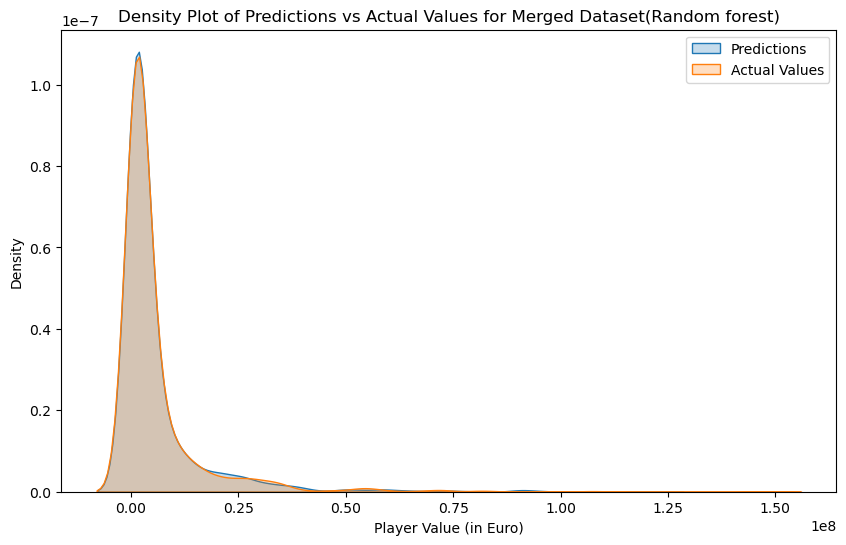

In [37]:
# Density Plot for Merged Dataset
plt.figure(figsize=(10, 6))
sns.kdeplot(y_pred, label='Predictions', fill=True)
sns.kdeplot(y_test, label='Actual Values', fill=True)
plt.title('Density Plot of Predictions vs Actual Values for Merged Dataset(Random forest)')
plt.xlabel('Player Value (in Euro)')
plt.legend()
plt.show()

[]

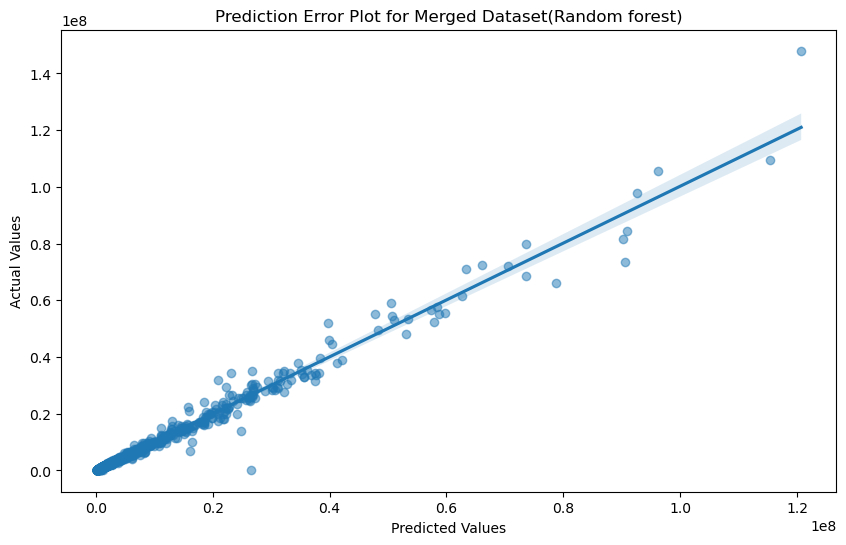

In [38]:
# Prediction Error Plot for Merged Dataset
plt.figure(figsize=(10, 6))
sns.regplot(x=y_pred, y=y_test, fit_reg=True, scatter_kws={'alpha':0.5})
plt.title('Prediction Error Plot for Merged Dataset(Random forest)')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.plot()

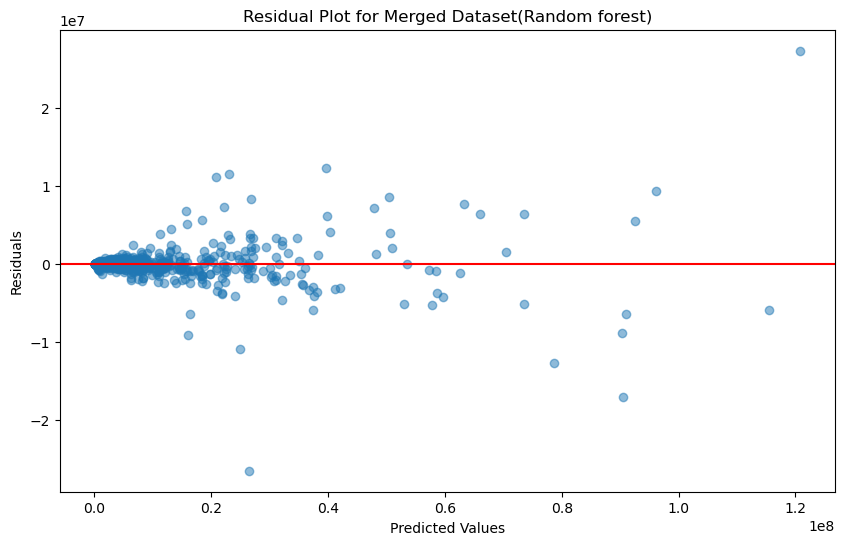

In [39]:
# Residual Plot for Merged Dataset
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.title('Residual Plot for Merged Dataset(Random forest)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

<Figure size 1000x600 with 0 Axes>

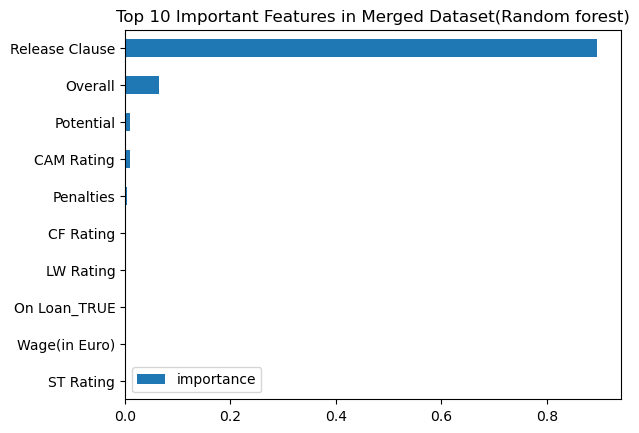

In [40]:
# Feature importance for merged dataset
feature_importances = pd.DataFrame(best_rf.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
plt.figure(figsize=(10, 6))
feature_importances.head(10).plot(kind='barh')
plt.title('Top 10 Important Features in Merged Dataset(Random forest)')
plt.gca().invert_yaxis()
plt.show()


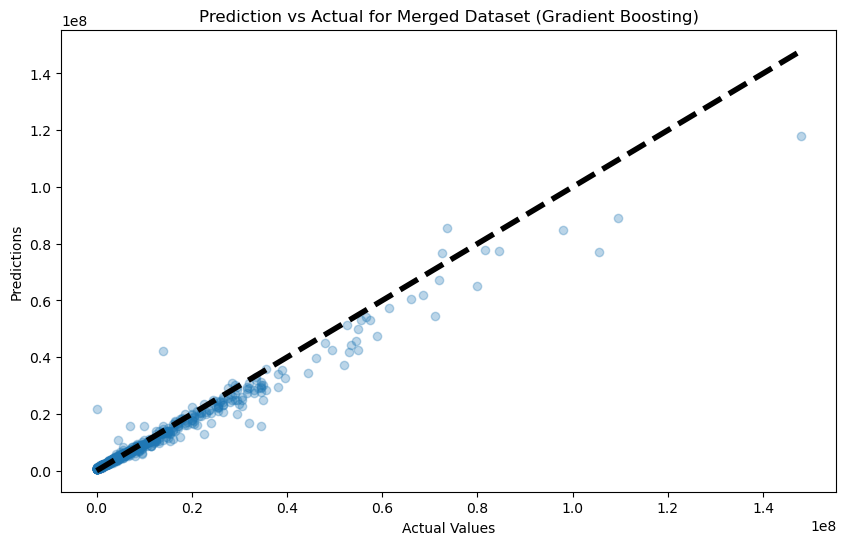

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Predictions
y_pred_gb = best_gb.predict(X_test)

# Merged Dataset Prediction vs Actual for Gradient Boosting
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_gb, alpha=0.3)
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title('Prediction vs Actual for Merged Dataset (Gradient Boosting)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.show()



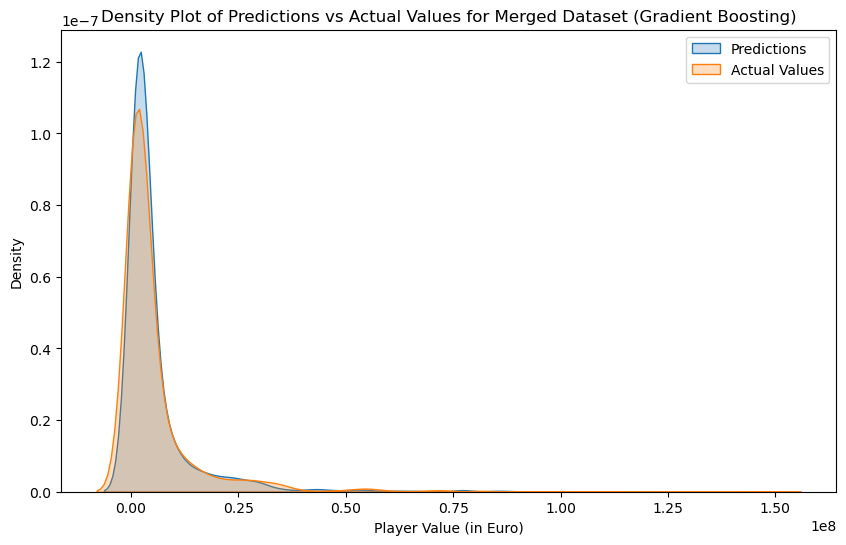

In [42]:

# Density Plot for Merged Dataset (Gradient Boosting)
plt.figure(figsize=(10, 6))
sns.kdeplot(y_pred_gb, label='Predictions', fill=True)
sns.kdeplot(y_test, label='Actual Values', fill=True)
plt.title('Density Plot of Predictions vs Actual Values for Merged Dataset (Gradient Boosting)')
plt.xlabel('Player Value (in Euro)')
plt.legend()
plt.show()


[]

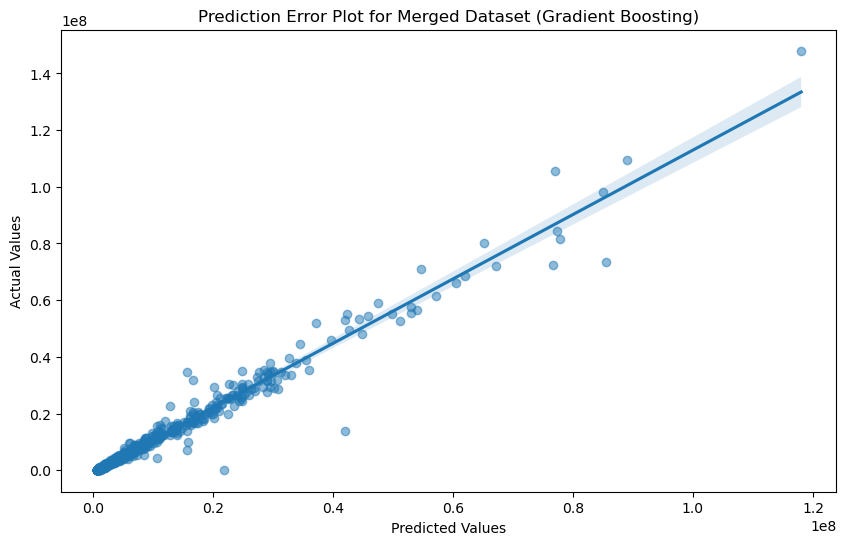

In [43]:
# Prediction Error Plot for Merged Dataset (Gradient Boosting)
plt.figure(figsize=(10, 6))
sns.regplot(x=y_pred_gb, y=y_test, fit_reg=True, scatter_kws={'alpha':0.5})
plt.title('Prediction Error Plot for Merged Dataset (Gradient Boosting)')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.plot()

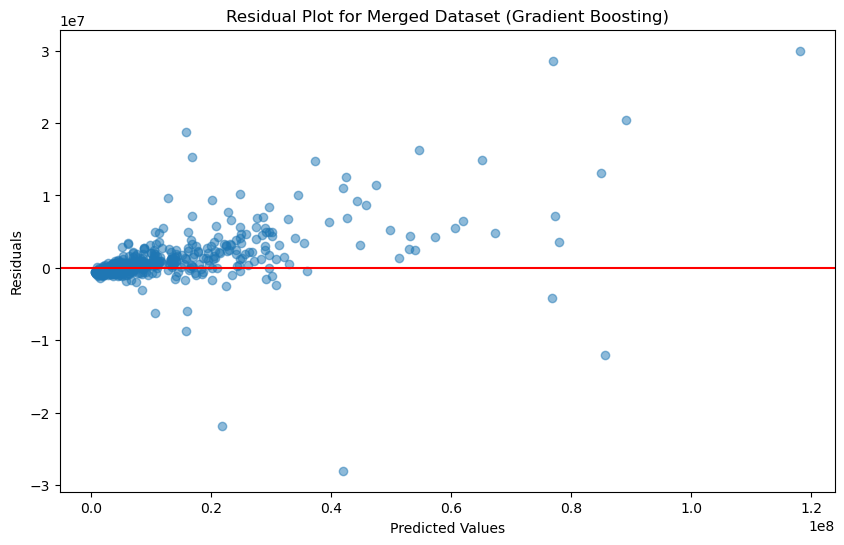

In [44]:
# Residual Plot for Merged Dataset (Gradient Boosting)
residuals_gb = y_test - y_pred_gb
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_gb, residuals_gb, alpha=0.5)
plt.title('Residual Plot for Merged Dataset (Gradient Boosting)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

<Figure size 1000x600 with 0 Axes>

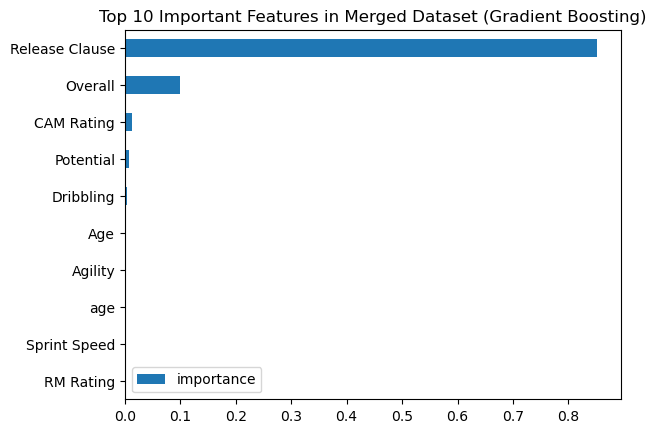

In [45]:
# Feature importance for merged dataset (Gradient Boosting)
feature_importances_gb = pd.DataFrame(best_gb.feature_importances_,
                                      index = X_train.columns,
                                      columns=['importance']).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
feature_importances_gb.head(10).plot(kind='barh')
plt.title('Top 10 Important Features in Merged Dataset (Gradient Boosting)')
plt.gca().invert_yaxis()
plt.show()

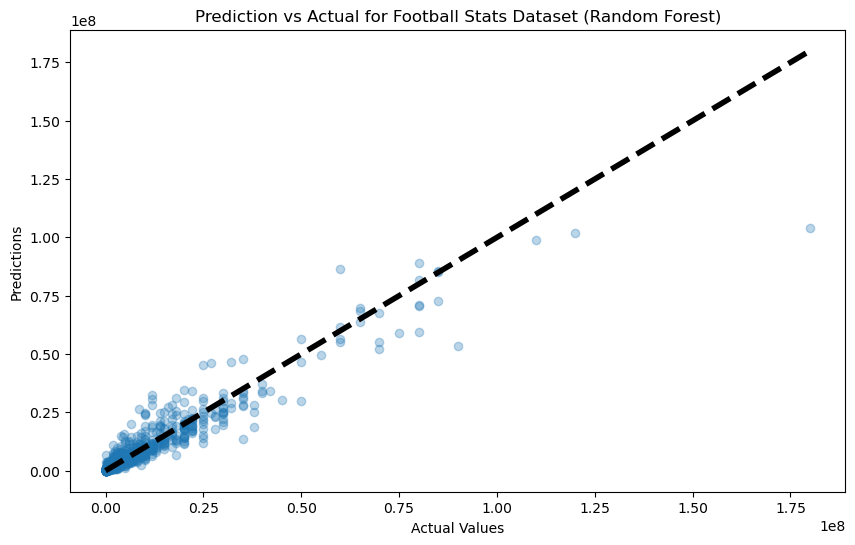

In [47]:
# Predictions
y_pred = best_rf_football.predict(X_test_football)

# Prediction vs Actual Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_football, y_pred, alpha=0.3)
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title('Prediction vs Actual for Football Stats Dataset (Random Forest)')
plt.plot([y_test_football.min(), y_test_football.max()], [y_test_football.min(), y_test_football.max()], 'k--', lw=4)
plt.show()



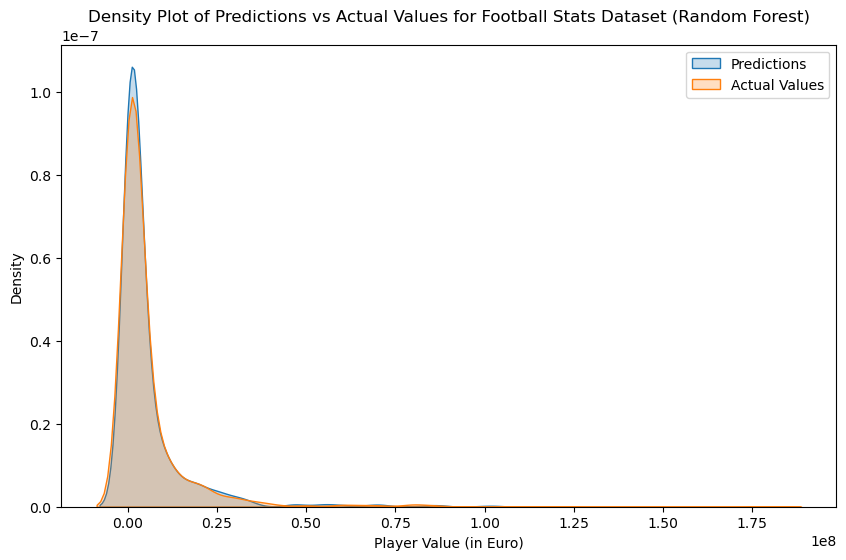

In [48]:
# Density Plot for Football Stats Dataset
plt.figure(figsize=(10, 6))
sns.kdeplot(y_pred, label='Predictions', fill=True)
sns.kdeplot(y_test_football, label='Actual Values', fill=True)
plt.title('Density Plot of Predictions vs Actual Values for Football Stats Dataset (Random Forest)')
plt.xlabel('Player Value (in Euro)')
plt.legend()
plt.show()


[]

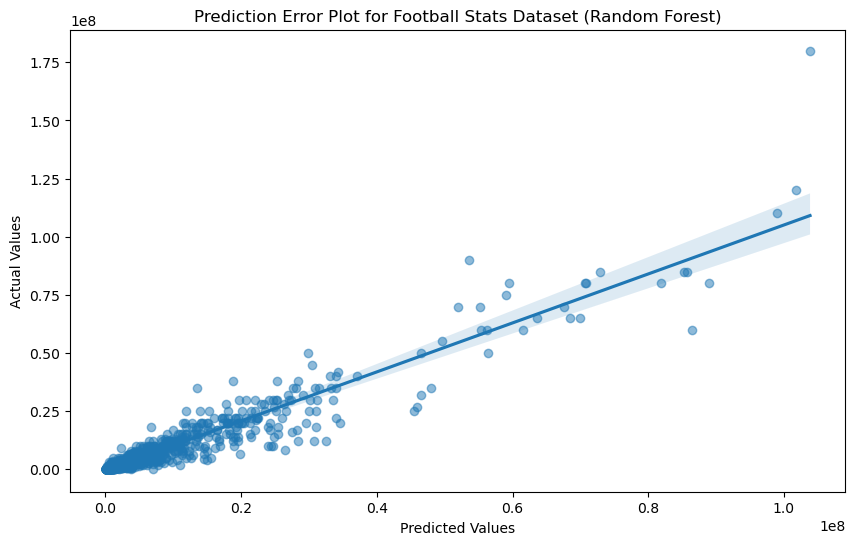

In [49]:
# Prediction Error Plot for Football Stats Dataset
plt.figure(figsize=(10, 6))
sns.regplot(x=y_pred, y=y_test_football, fit_reg=True, scatter_kws={'alpha':0.5})
plt.title('Prediction Error Plot for Football Stats Dataset (Random Forest)')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.plot()


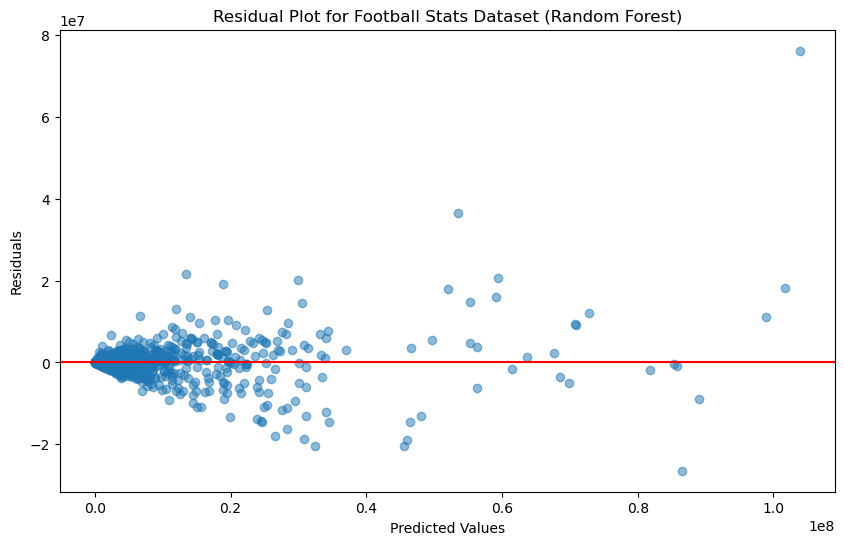

In [50]:

# Residual Plot for Football Stats Dataset
residuals = y_test_football - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.title('Residual Plot for Football Stats Dataset (Random Forest)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

<Figure size 1000x600 with 0 Axes>

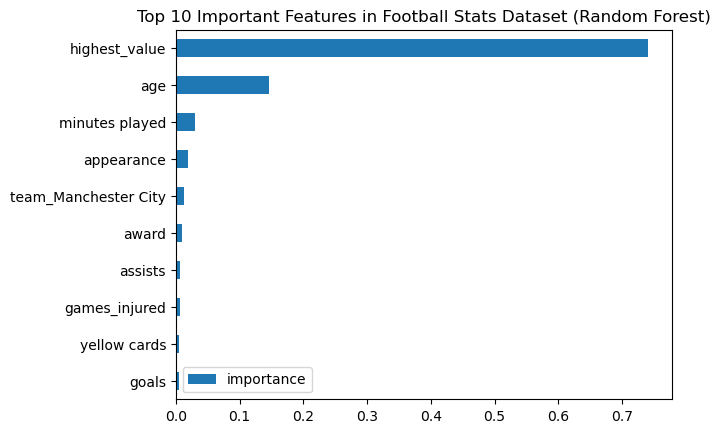

In [51]:
# Feature Importance for Football Stats Dataset
feature_importances = pd.DataFrame(best_rf_football.feature_importances_,
                                   index = X_train_football.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
feature_importances.head(10).plot(kind='barh')
plt.title('Top 10 Important Features in Football Stats Dataset (Random Forest)')
plt.gca().invert_yaxis()
plt.show()

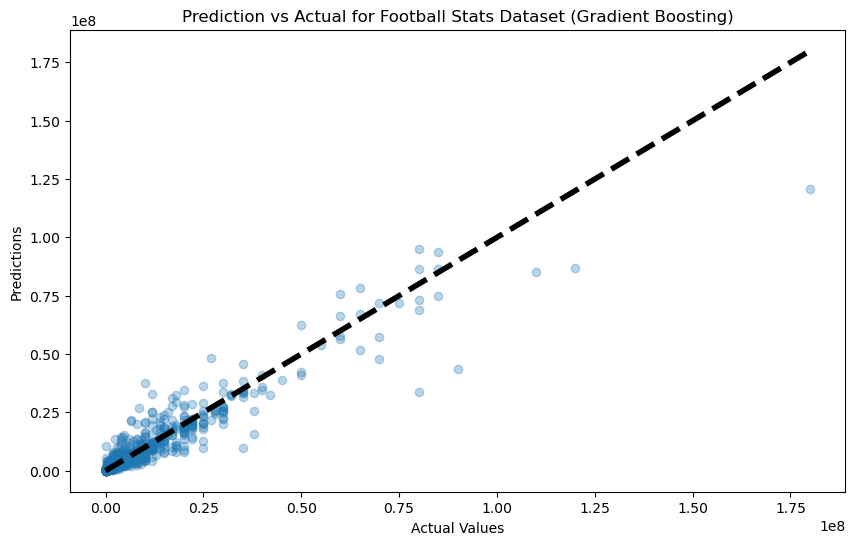

In [53]:
# Predictions
y_pred_gb_football = best_gb_football.predict(X_test_football)

# Prediction vs Actual Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_football, y_pred_gb_football, alpha=0.3)
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title('Prediction vs Actual for Football Stats Dataset (Gradient Boosting)')
plt.plot([y_test_football.min(), y_test_football.max()], [y_test_football.min(), y_test_football.max()], 'k--', lw=4)
plt.show()



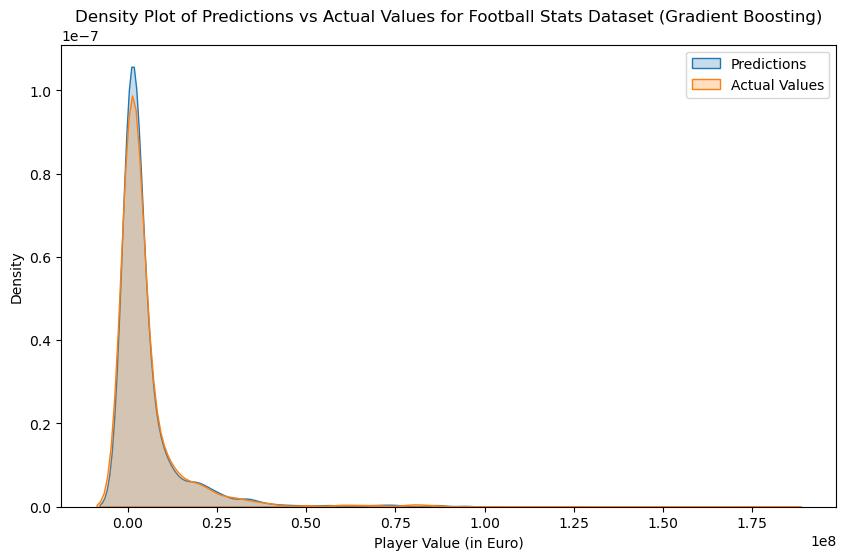

In [54]:
# Density Plot for Football Stats Dataset
plt.figure(figsize=(10, 6))
sns.kdeplot(y_pred_gb_football, label='Predictions', fill=True)
sns.kdeplot(y_test_football, label='Actual Values', fill=True)
plt.title('Density Plot of Predictions vs Actual Values for Football Stats Dataset (Gradient Boosting)')
plt.xlabel('Player Value (in Euro)')
plt.legend()
plt.show()

[]

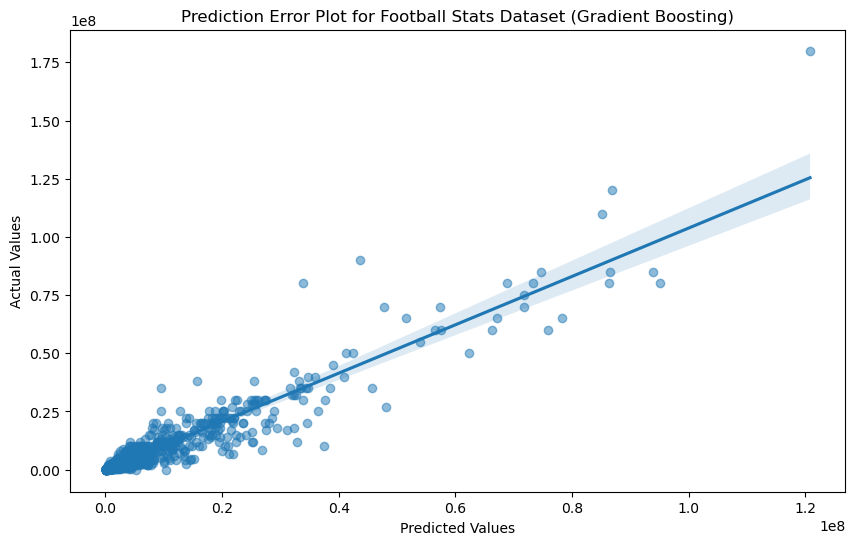

In [55]:
# Prediction Error Plot for Football Stats Dataset
plt.figure(figsize=(10, 6))
sns.regplot(x=y_pred_gb_football, y=y_test_football, fit_reg=True, scatter_kws={'alpha': 0.5})
plt.title('Prediction Error Plot for Football Stats Dataset (Gradient Boosting)')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.plot()

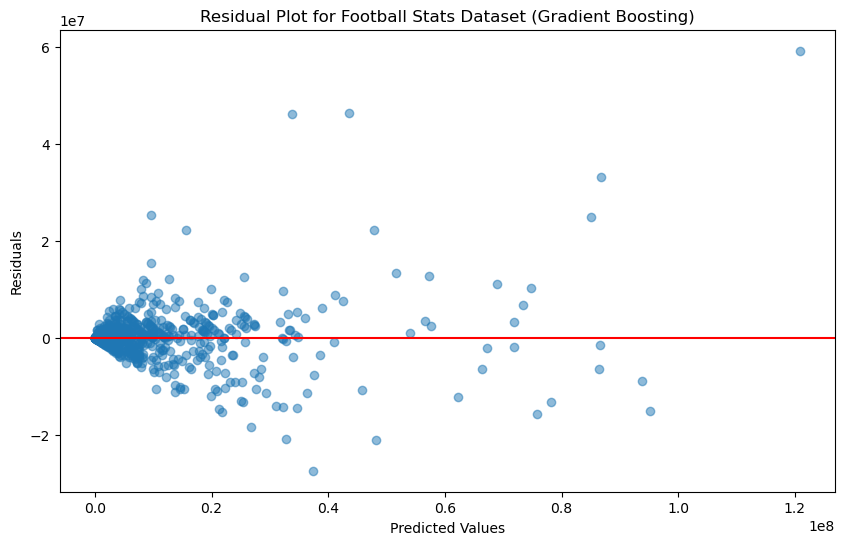

In [56]:
# Residual Plot for Football Stats Dataset
residuals_gb = y_test_football - y_pred_gb_football
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_gb_football, residuals_gb, alpha=0.5)
plt.title('Residual Plot for Football Stats Dataset (Gradient Boosting)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()


<Figure size 1000x600 with 0 Axes>

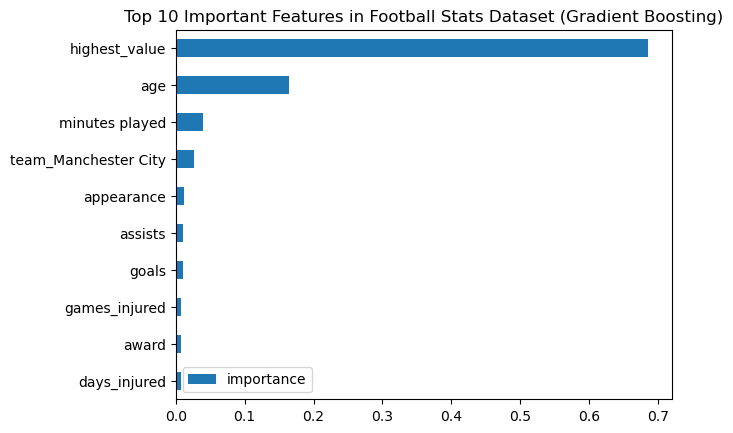

In [57]:
# Feature Importance for Football Stats Dataset
feature_importances_gb = pd.DataFrame(best_gb_football.feature_importances_,
                                      index=X_train_football.columns,
                                      columns=['importance']).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
feature_importances_gb.head(10).plot(kind='barh')
plt.title('Top 10 Important Features in Football Stats Dataset (Gradient Boosting)')
plt.gca().invert_yaxis()
plt.show()

# SHAP

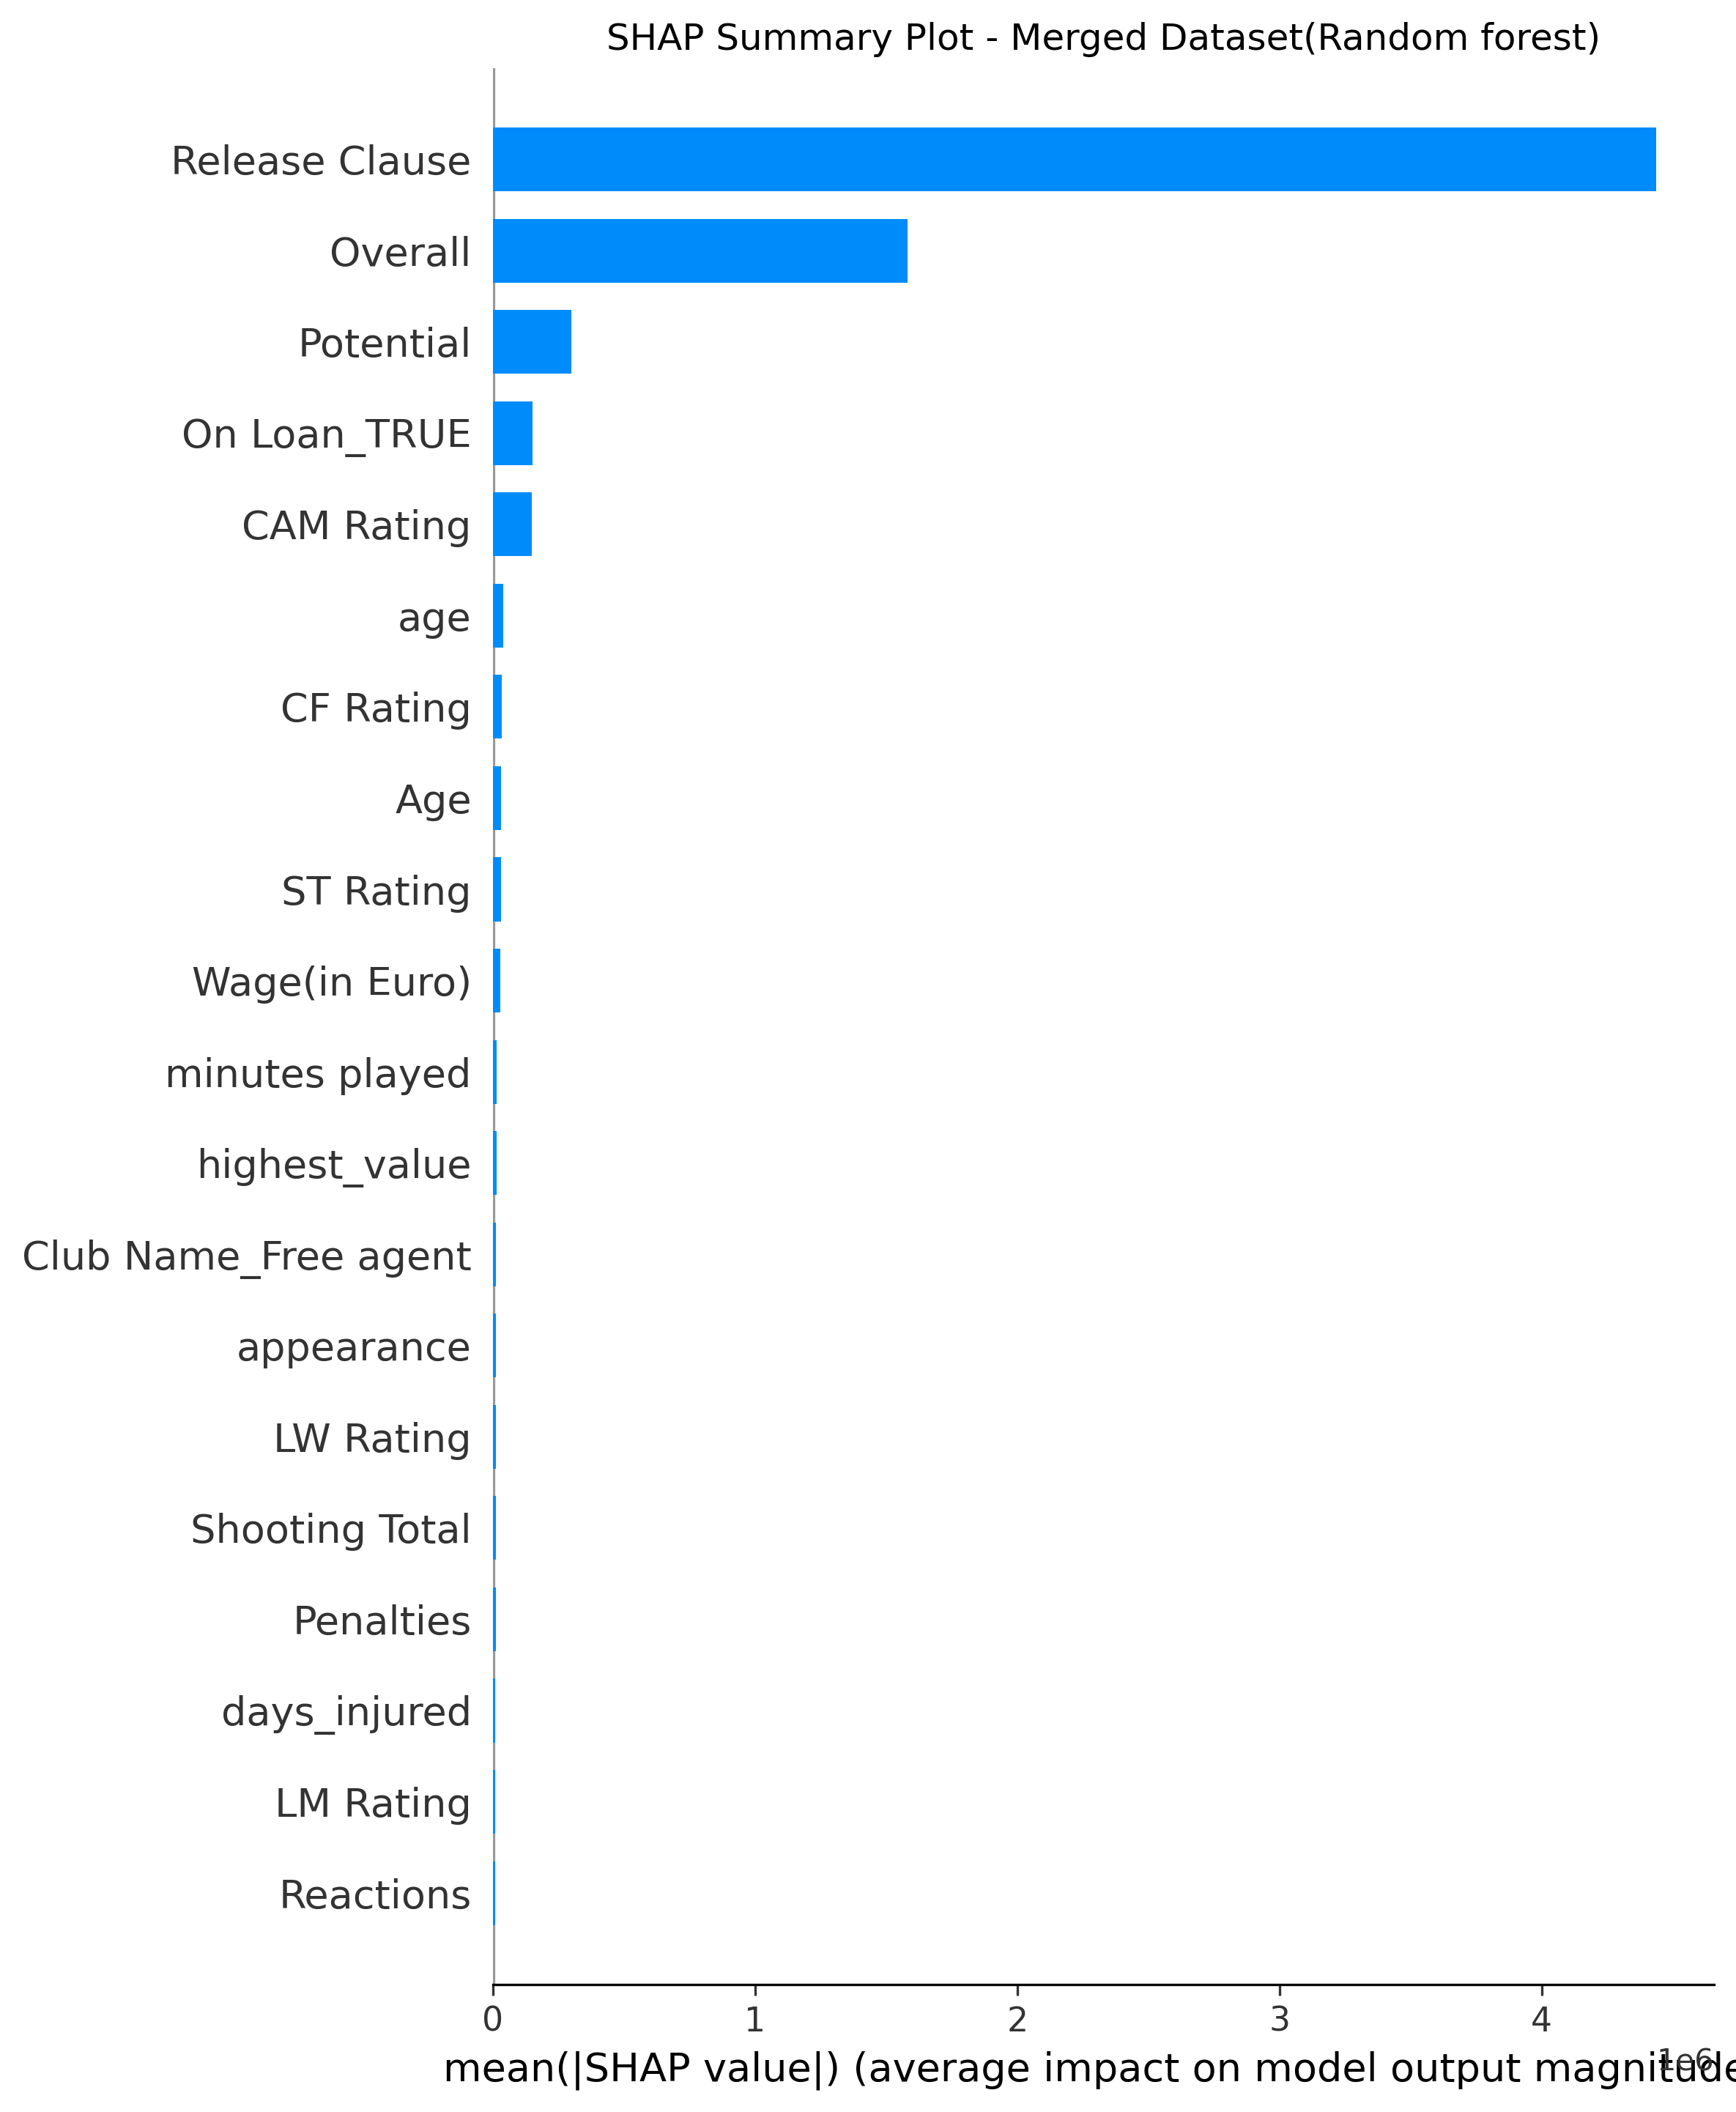

In [73]:
import shap
import matplotlib.pyplot as plt

# Initialize the SHAP values explainer for merged dataset
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)

# Summary plot of SHAP values for merged dataset
plt.figure(figsize=(20, 15), dpi=300)
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("SHAP Summary Plot - Merged Dataset(Random forest)")
plt.savefig("shap_summary_plot_merged_dataset.png", bbox_inches='tight')
plt.show()




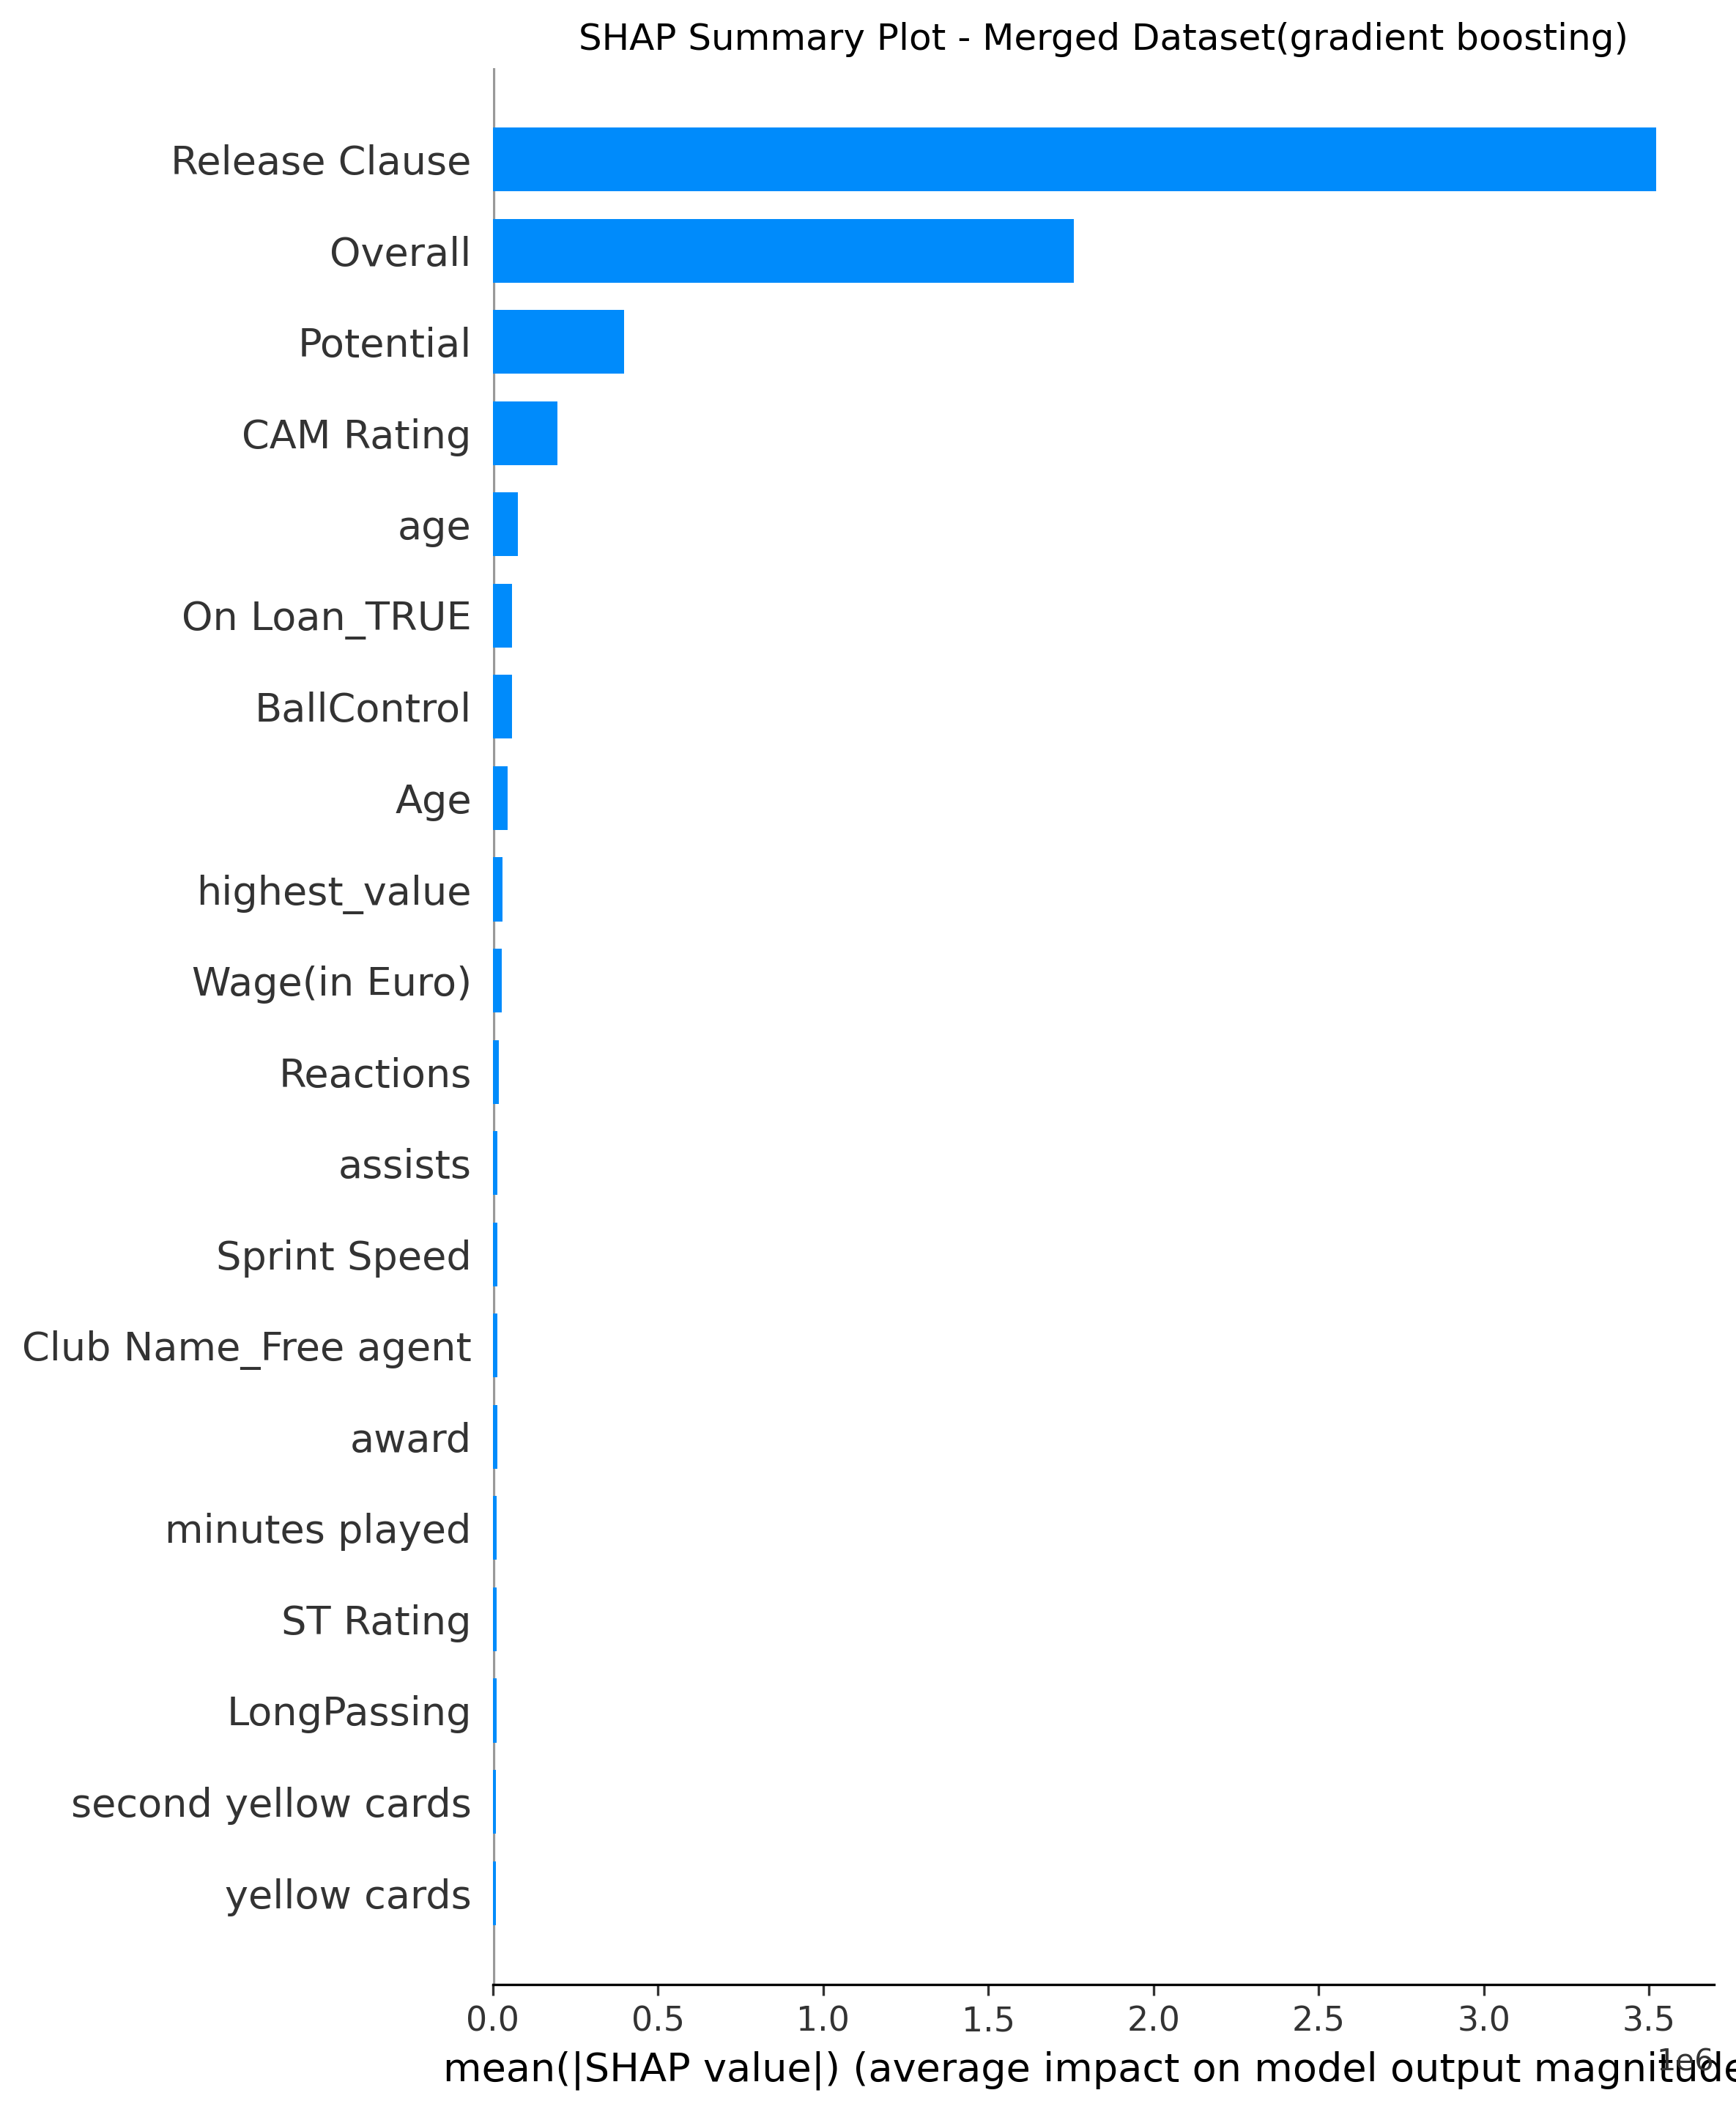

In [74]:
# Initialize the SHAP values explainer for merged dataset
explainer = shap.TreeExplainer(best_gb)
shap_values = explainer.shap_values(X_test)

# Summary plot of SHAP values for merged dataset
plt.figure(figsize=(20, 15), dpi=300)
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("SHAP Summary Plot - Merged Dataset(gradient boosting)")
plt.savefig("shap_summary_plot_merged_dataset.png", bbox_inches='tight')
plt.show()

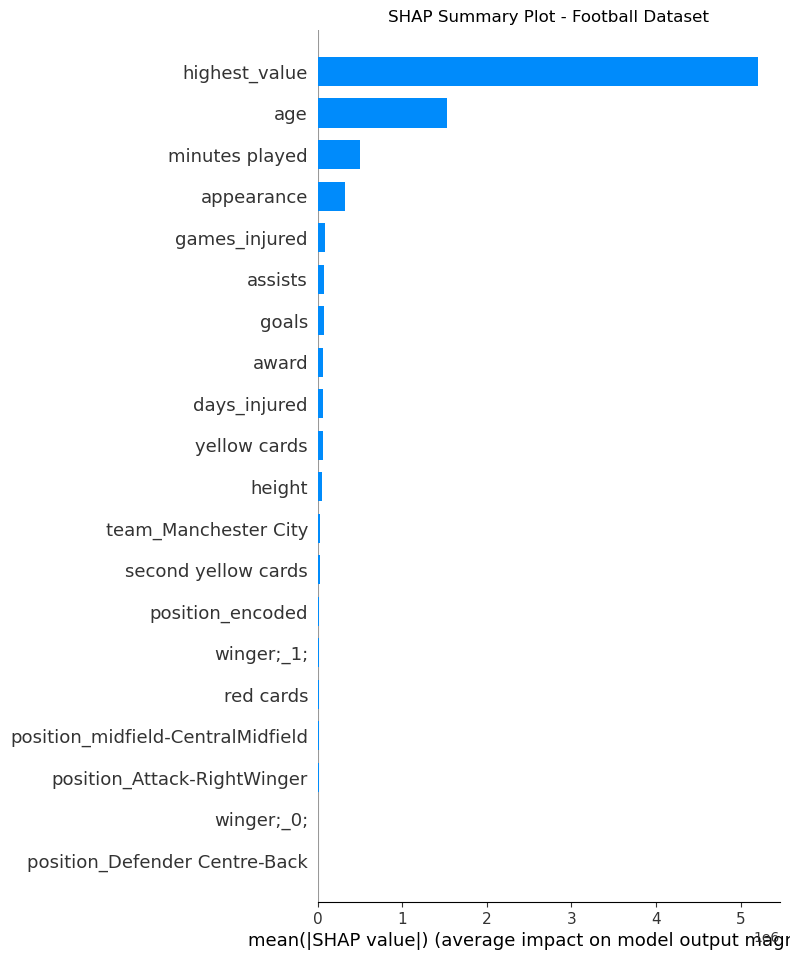

<Figure size 640x480 with 0 Axes>

In [62]:
# Initialize the SHAP values explainer for merged dataset
explainer_football = shap.TreeExplainer(best_rf_football)
shap_values_football = explainer_football.shap_values(X_test_football)

# Summary plot of SHAP values for merged dataset
plt.figure()
shap.summary_plot(shap_values_football, X_test_football, plot_type="bar", show=False)
plt.title("SHAP Summary Plot - Football Dataset")

# SHAP Impact Plot for Merged Dataset
shap.initjs()
plt.figure()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])
plt.show()

